In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import lmfit
import ompy as om
import json

import scipy.stats as stats
import scipy.integrate as integrate
import scipy.constants as constants
import sys

#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter, LogFormatter)

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
from ipynb.fs.full.functions import *

In [4]:
#setting figsize
plt.rcParams["figure.figsize"] = (8,6)

plt.rcParams["figure.autolayout"] = True

#size of errorbar caps
plt.rcParams["errorbar.capsize"] = 3

#setting label sizes
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12


#set linewidths and markersize
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.markersize'] = 7

#set x and y axis
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.top'] = True

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['legend.frameon'] = False

#setting different dpi for notebook and saving
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams["figure.dpi"] = 80

plt.rcParams['text.usetex'] = True

In [5]:
def set_size(width=390, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [6]:
om.__full_version__;
np.random.seed(1382398)

In [7]:
kevperbin185 = True
kevperbin120 = False

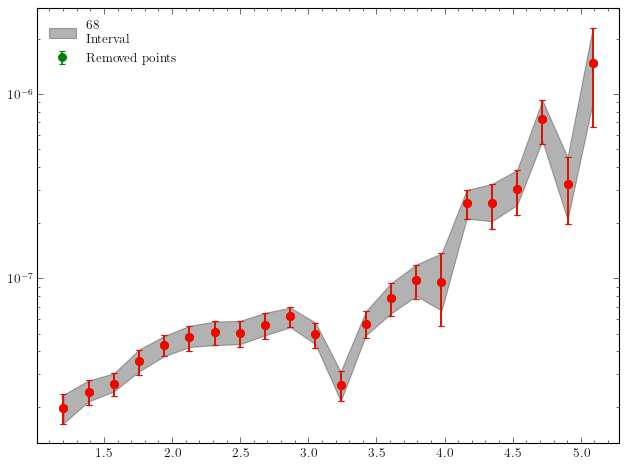

In [8]:
#185 kev/bin
#need to remove last six points
if kevperbin185 == True:
    gsf_values = read_OMPy('04-26_10:06:05')[0] #185 kev/bin
    [energy_gsf, gsf_median, gsf_error_upper, gsf_error_lower, gsf_error] = gsf_values
    
    energy_gsf_ompy = energy_gsf
    gsf_ompy_median = gsf_median
    
    gsf_ompy_error_fit = np.zeros(len(gsf_ompy_median))
    for i in range(len(gsf_ompy_error_fit)):
        upper = gsf_error_upper[i]-gsf_ompy_median[i]
        lower = gsf_ompy_median[i]-gsf_error_lower[i]
        gsf_ompy_error_fit[i] = max(upper, lower) 
    
    
    
    fig, ax = plt.subplots()
    ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error_fit, fmt='o', color='green', label='Removed points')
    ax.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.3, label='68% Confidence\n Interval')
    ax.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange')
    
    #-6 removes the last six points from this analysis, as they are very uncertain
    #energy_gsf_ompy = np.asarray(energy_gsf_ompy[0:-6])
    #gsf_ompy_median = np.asarray(gsf_ompy_median[0:-6])
    #gsf_ompy_error_fit = np.asarray(gsf_ompy_error_fit[0:-6])
    #gsf_error_lower = np.asarray(gsf_error_lower[0:-6])
    #gsf_error_upper = np.asarray(gsf_error_upper[0:-6])
    ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error_fit, fmt='o', color='red')
    ax.set_yscale('log')
    ax.legend()

In [9]:
#120 kev/bin
#removes 5 last points and dips
if kevperbin120 == True:
    gsf_values = read_OMPy('04-26_09:12:21')[0] #120 kev/bin
    
    [energy_gsf, gsf_median, gsf_error_upper, gsf_error_lower, gsf_error] = gsf_values
    
    energy_gsf_ompy = energy_gsf
    gsf_ompy_median = gsf_median
    
    gsf_ompy_error_fit = np.zeros(len(gsf_ompy_median))
    for i in range(len(gsf_ompy_error_fit)):
        upper = gsf_error_upper[i]-gsf_ompy_median[i]
        lower = gsf_ompy_median[i]-gsf_error_lower[i]
        gsf_ompy_error_fit[i] = max(upper, lower) 
    
    
    
    fig, ax = plt.subplots()
    ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error_fit, fmt='o', color='green', label='Removed points')
    ax.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.3, label='68% Confidence\n Interval')
    ax.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange')
    
    #Need to remove last five points and drops and index=19 and index=24 with the huge dips
    energy_gsf_ompy = np.delete(np.asarray(energy_gsf_ompy[0:]), [19,24])
    gsf_ompy_median = np.delete(np.asarray(gsf_ompy_median[0:]), [19,24])
    gsf_ompy_error_fit = np.delete(np.asarray(gsf_ompy_error_fit[0:]), [19,24])
    gsf_error_lower = np.delete(np.asarray(gsf_error_lower[0:]), [19,24])
    gsf_error_upper = np.delete(np.asarray(gsf_error_upper[0:]), [19,24])
    ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error_fit, fmt='o', color='red')
    ax.set_yscale('log')
    ax.legend()

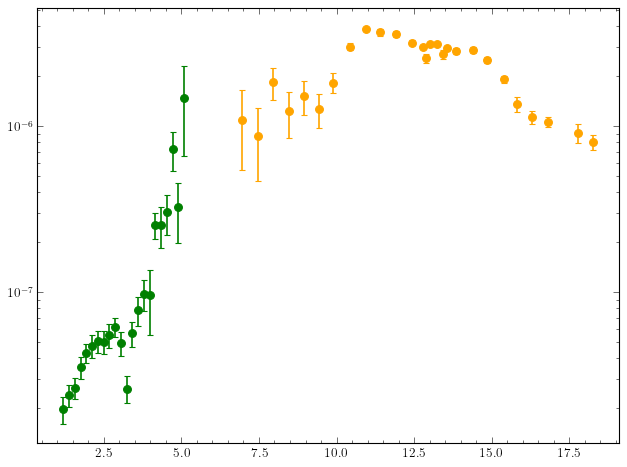

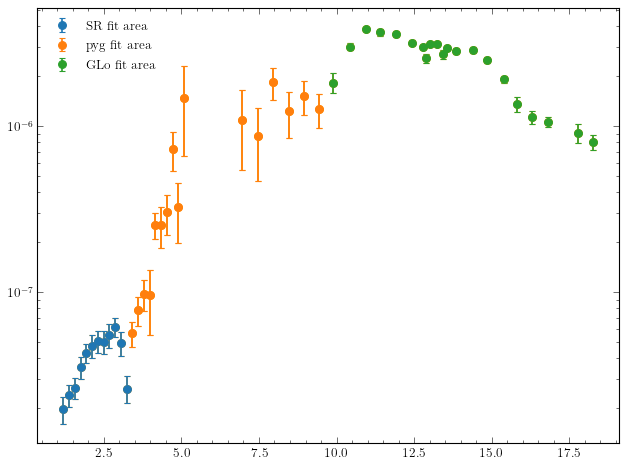

In [10]:
with open('u234_g_x.json') as K:
    data_U233 = json.load(K)
datasets_U233=data_U233["datasets"]

energy_exp1, gsf_exp1, gsf_exp1_error =  extract_JSON(datasets_U233[0]['data'], 5, 0, 1)
gsf_exp1 = cs_to_gsf(energy_exp1, gsf_exp1)
gsf_exp1_error = cs_to_gsf(energy_exp1, gsf_exp1_error)

fig, ax = plt.subplots()

ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error_fit, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.set_yscale('log')
fig.show()

#pasting all data together

all_data_error = np.concatenate([gsf_ompy_error_fit, gsf_exp1_error])
all_data_energy = np.concatenate([energy_gsf_ompy, energy_exp1])
all_data = np.concatenate([gsf_ompy_median, gsf_exp1])

#making cuts at certain energies
SR_low_cut = 0
for i in range(len(all_data_energy)):
    if all_data_energy[i]>3.35:
        SR_hi_cut=i
        pyg_low_cut = i
        break
for i in range(len(all_data_energy)):
    if all_data_energy[i]>9.5:
        pyg_hi_cut = i
        GLo_low_cut = i
        break

#SR_low_cut = 0
#SR_hi_cut = 11
#pyg_low_cut = 12
#pyg_hi_cut = 25
#GLo_low_cut = 25

fig, ax = plt.subplots()
ax.errorbar(x=all_data_energy, y=all_data, yerr=all_data_error, fmt='o', color='orange')
ax.errorbar(x=all_data_energy[SR_low_cut:SR_hi_cut], y=all_data[SR_low_cut:SR_hi_cut], yerr=all_data_error[SR_low_cut:SR_hi_cut], fmt='o', label='SR fit area')
ax.errorbar(x=all_data_energy[pyg_low_cut:pyg_hi_cut], y=all_data[pyg_low_cut:pyg_hi_cut], yerr=all_data_error[pyg_low_cut:pyg_hi_cut], fmt='o', label='pyg fit area')
ax.errorbar(x=all_data_energy[GLo_low_cut:], y=all_data[GLo_low_cut:], yerr=all_data_error[GLo_low_cut:], fmt='o', label='GLo fit area')

ax.legend()
ax.set_yscale('log')
fig.show()

In [11]:
def f_fit_total(par, E):

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR'], par['E_SR_2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR'], par['Gamma_SR_2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR'], par['sigma_SR_2']])

    # Calculating the sum of the singular GLOs
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
    for i in [0,1,2,3,4,5]:
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [12]:
def f_fit_GLo(par, E):
    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in range(2):
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [13]:
def f_fit_pygs(par, E):
    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_pyg1'],     par['E_pyg2']])
    Gamma = np.array([par['Gamma_pyg1'], par['Gamma_pyg2']])
    sigma = np.array([par['sigma_pyg1'], par['sigma_pyg2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in [0,1]:
        output += functions[i+2](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [14]:
def f_fit_SR(par, E):
    functions = p0_functions

    T = 0
    EX = np.array(   [par['E_SR1'], par['E_SR2']])
    Gamma = np.array([par['Gamma_SR1'], par['Gamma_SR2']])
    sigma = np.array([par['sigma_SR1'], par['sigma_SR2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in [0,1]:
        output += functions[i+4](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [15]:
#function for plotting singular fits
def fit_plot_singular(par, E, j):
    """ Marianne: plot fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR1'],     par['E_SR2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR1'], par['Gamma_SR2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR1'], par['sigma_SR2']])

    return functions[j](E, EX[j], Gamma[j], sigma[j], T)

In [16]:
#make parameters object for plotting
params = lmfit.Parameters()
input_params = lmfit.Parameters()
def update_params(pars, p0):
    #                (Name,          Value
    pars.add_many(('T_f',         p0[0]),
                    ('E_GLo1',      p0[1]),
                    ('Gamma_GLo1',  p0[2]),
                    ('sigma_GLo1',  p0[3]),
                    ('E_GLo2',      p0[4]),
                    ('Gamma_GLo2',  p0[5]),
                    ('sigma_GLo2',  p0[6]),
                    ('E_pyg1',      p0[7]),
                    ('Gamma_pyg1',  p0[8]),
                    ('sigma_pyg1',  p0[9]),
                    ('E_pyg2',      p0[10]),
                    ('Gamma_pyg2',  p0[11]),
                    ('sigma_pyg2',  p0[12]),
                    ('E_SR1',       p0[13]),
                    ('Gamma_SR1',   p0[14]),
                    ('sigma_SR1',   p0[15]),
                    ('E_SR2',       p0[16]),
                    ('Gamma_SR2',   p0[17]),
                    ('sigma_SR2',   p0[18]))



In [17]:
#declaring fit parameters

#Define parameters & start values for the GLO
E_GLo1 = 11.4 # centroid (MeV)
Gamma_GLo1 = 2.0 # width (MeV)
sigma_GLo1 = 300 # peak cross section (mb)
E_GLo2 = 14.0 # centroid (MeV)
Gamma_GLo2 = 4.3 # width (MeV)
sigma_GLo2 = 480 # peak cross section (mb)
T_f    = 0.2 #constant temperature of final states (MeV)

#START VALUES pygmy resonance 1
E_pyg1 = 4.5 # Pygmy centroid (MeV)
Gamma_pyg1 = 0.4 # Width (MeV)
Gamma_pyg1 = 5. # Width (MeV)
sigma_pyg1 = 5.0 #peak cross section (mb)

#START VALUES pygmy 2/spinflip resonance
E_pyg2 = 7.0 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_pyg2 = 1.5 #Width (MeV)
sigma_pyg2 = 20.0 #peak cross section (mb)

#START VALUES Pygmy scissors resonance
E_SR1 = 2.2 #SR1 centroid (MeV)
Gamma_SR1 = 1.5 #Width (MeV)
sigma_SR1 = 1.0 #peak cross section (mb)

E_SR2 = 2.7 #SR2 centroid (MeV)
Gamma_SR2 = Gamma_SR1 #Width (MeV)
sigma_SR2 = sigma_SR1 #peak cross section (mb)


p0 = [T_f, E_GLo1, Gamma_GLo1, sigma_GLo1,
           E_GLo2, Gamma_GLo2, sigma_GLo2,
           E_pyg1, Gamma_pyg1, sigma_pyg1,
           E_pyg2, Gamma_pyg2, sigma_pyg2,
           E_SR1,  Gamma_SR1,  sigma_SR1,
           E_SR2,  Gamma_SR2,  sigma_SR2]
p0_functions = [GLo, GLo, SLo, SLo, SLo, SLo]
p0_functions_names = ['GLo1', 'GLo2', 'pyg1', 'pyg2', 'SR1', 'SR2']
nuclei = "233U"
update_params(input_params, p0)


#Experimental Kopecky data
fEx = np.asarray([12.14E-08])
fEerr = np.asarray([3.92E-08])
fEene = np.asarray([3.9])
fEeneerr = np.asarray([0.00])
fMx = np.asarray([2.11E-08])
fMerr = np.asarray([0.78E-08])
fMene = np.asarray([4.4])
fMeneerr = np.asarray([0.0])

Sn = 5.762

In [18]:
minimum = np.array(p0)*.3
maximum = np.array(p0)*2.5

In [19]:
params_GLo = lmfit.Parameters()

#                (Name,          Value,  Weather or not to include in fit, 
#                 |              |       |     Lower fit limit, 
#                 |              |       |     |            Upper fit limit)
params_GLo.add_many(('T_f',          p0[0],  False, 0,  .2),
                    ('E_GLo1',       p0[1],  True, minimum[1],  maximum[1]),
                    ('Gamma_GLo1',   p0[2],  True, minimum[2],  maximum[2]),
                    ('sigma_GLo1',   p0[3],  True, minimum[3],  maximum[3]),
                    ('E_GLo2',       p0[4],  True, minimum[4],  maximum[4]),
                    ('Gamma_GLo2',   p0[5],  True, minimum[5],  maximum[5]),
                    ('sigma_GLo2',   p0[6],  True, minimum[6],  maximum[6]),)

energy_GLo = all_data_energy[GLo_low_cut:]
data_GLo = all_data[GLo_low_cut:]
error_GLo = all_data_error[GLo_low_cut:]



def residuals_GLo(parameters):
    return (f_fit_GLo(parameters, energy_GLo) - data_GLo)**2/(error_GLo**2)

results_GLo = lmfit.minimize(fcn=residuals_GLo, params=params_GLo, method="leastsq")
print(results_GLo.params.pretty_print())

p0[0:7] = [results_GLo.params['T_f'].value, results_GLo.params['E_GLo1'].value, results_GLo.params['Gamma_GLo1'].value,
           results_GLo.params['sigma_GLo1'].value, results_GLo.params['E_GLo2'].value, results_GLo.params['Gamma_GLo2'].value,
           results_GLo.params['sigma_GLo2'].value]
update_params(params, p0)


Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_GLo1          11.4     3.42     28.5   0.1575     True     None     None
E_GLo2         14.08      4.2       35  0.06156     True     None     None
Gamma_GLo1     2.608      0.6        5    0.515     True     None     None
Gamma_GLo2     3.244     1.29    10.75   0.5654     True     None     None
T_f              0.2        0      0.2        0    False     None     None
sigma_GLo1       453       90      750    23.82     True     None     None
sigma_GLo2     309.5      144     1200    36.81     True     None     None
None


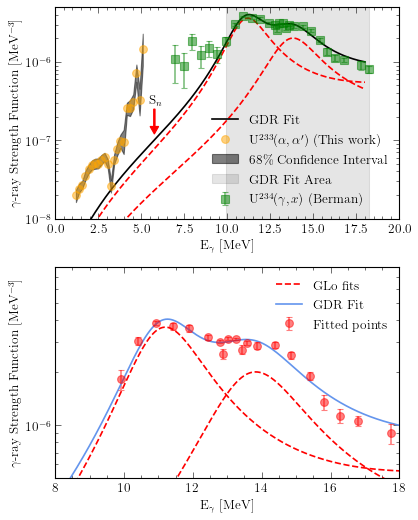

In [20]:


fig = plt.figure(figsize = set_size(subplots=(2,1)))
gs = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])

# Actual best-fit curve
# Extract values from the fit
# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax1.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont), '-', color="black", label="GDR Fit")
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=0), '--', color="red")
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=1), '--', color="red")
ax1.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.5, label='68\% Confidence Interval')
ax1.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange', alpha=0.5, label='U$^{233}(\\alpha,\\alpha^\prime)$ (This work)')
ax1.arrow(x=Sn, y=2.5e-7, dx=0, dy=-1e-7, width=0.08, head_width=.5, head_length=3e-8, color='r')
ax1.text(Sn-.3, 3e-7, "S$_n$") 
ax1.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$ (Berman)")
ax1.fill_between([energy_GLo[0], energy_GLo[-1]], [1,1], [0,0], color='black', alpha=0.1, label='GDR Fit Area')
ax1.set_ylim(1e-8,5e-6)
ax1.set_xlim(0,20)
ax1.set_yscale('log')

ax1.legend()

#h, l = ax1.get_legend_handles_labels()
#ax3.set_yticks([])
#ax3.set_xticks([])
#ax3.legend(h, l, ncol=2, fontsize=10, frameon=True, facecolor='white', framealpha=.9, loc='center')
#ax3.axis('off')

#plot only fit
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=1),'--', color="red", label='GLo fits')
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=0),'--', color="red")
ax2.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont), '-', color="cornflowerblue", label="GDR Fit")
ax2.errorbar(x=energy_GLo, y=data_GLo, yerr=error_GLo, fmt='o', color='red', alpha=0.5, label='Fitted points')
ax2.set_ylim(5e-7,8e-6)
ax2.set_xlim(8,18)
ax2.set_yscale('log')
ax2.legend()

#ax2.yaxis.set_minor_formatter(NullFormatter())
#ax2.set_yticks([1e-6,2e-6])
#ax2.set_yticklabels(['1e-6', '2e-6'])
ax1.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax2.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax1.set_xlabel('E$_\gamma$  [MeV]')
ax2.set_xlabel('E$_\gamma$  [MeV]')
fig.savefig('GDR_fit')
if kevperbin120 == True:
    fig.savefig('GDR_fit_120')
if kevperbin185 == True:
    fig.savefig('GDR_fit_185')

In [21]:
#Fit the pygmy resonances, in order to get the correct background for 
# the scissor resonance fit

params_pygs = lmfit.Parameters()

if kevperbin120 == True:
    params_pygs.add_many(('T_f',         p0[0],  False, p0[0]-1,     p0[0]+1),
                         ('E_pyg1',      p0[7],  True,  3,  7.5),
                         ('Gamma_pyg1',  p0[8],  True,  2,  maximum[8]),
                         ('sigma_pyg1',  p0[9],  True,  minimum[9],  1000),
                         ('E_pyg2',      p0[10], True,  minimum[10], maximum[10]),
                         ('Gamma_pyg2',  p0[11], True,  minimum[11], maximum[11]),
                         ('sigma_pyg2',  p0[12], True,  minimum[12], 1000))

if kevperbin185 == True:
    params_pygs.add_many(('T_f',         p0[0],  False, p0[0]-1,     p0[0]+1),
                         ('E_pyg1',      p0[7],  True,  3,  7.5),
                         ('Gamma_pyg1',  p0[8],  True,  minimum[8],  maximum[8]),
                         ('sigma_pyg1',  p0[9],  True,  minimum[9],  1000),
                         ('E_pyg2',      p0[10], True,  minimum[10], maximum[10]),
                         ('Gamma_pyg2',  p0[11], True,  minimum[11], maximum[11]),
                         ('sigma_pyg2',  p0[12], True,  minimum[12], 1000))

energy_pyg = all_data_energy[pyg_low_cut:pyg_hi_cut]
data_pyg = all_data[pyg_low_cut:pyg_hi_cut]
error_pyg = all_data_error[pyg_low_cut:pyg_hi_cut]

for i in range(len(data_pyg)):
    if data_pyg[i]-f_fit_GLo(results_GLo.params, E=energy_pyg[i])<0:
        data_pyg[i] = 0
    else:
        data_pyg[i] = data_pyg[i]-f_fit_GLo(results_GLo.params, E=energy_pyg[i])

def residuals_pyg(parameters):
    return (f_fit_pygs(parameters, energy_pyg) - data_pyg)**2/(error_pyg**2)

results_pygs = lmfit.minimize(fcn=residuals_pyg, params=params_pygs, method="leastsq")
print(results_pygs.params.pretty_print())

p0[7:13] = [results_pygs.params['E_pyg1'].value, results_pygs.params['Gamma_pyg1'].value,
           results_pygs.params['sigma_pyg1'].value, results_pygs.params['E_pyg2'].value, results_pygs.params['Gamma_pyg2'].value,
           results_pygs.params['sigma_pyg2'].value]
update_params(params, p0)

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_pyg1         5.018        3      7.5   0.8567     True     None     None
E_pyg2         8.169      2.1     17.5   0.1719     True     None     None
Gamma_pyg1       1.5      1.5     12.5   0.5155     True     None     None
Gamma_pyg2    0.5452     0.45     3.75    0.927     True     None     None
T_f              0.2     -0.8      1.2        0    False     None     None
sigma_pyg1     13.48      1.5     1000    16.79     True     None     None
sigma_pyg2     203.2        6     1000    397.2     True     None     None
None


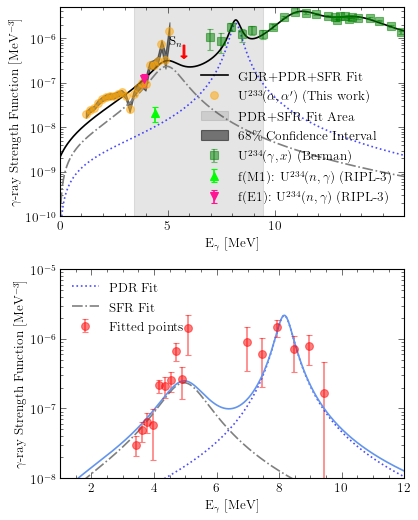

In [22]:

fig = plt.figure(figsize = set_size(subplots=(2,1)))
gs = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])

x_values_cont = np.linspace(0, 18, 1000)
ax1.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont)+f_fit_pygs(results_pygs.params, E=x_values_cont), '-', color="black", label="GDR+PDR+SFR Fit")
ax1.fill_between([energy_pyg[0], energy_pyg[-1]], [1,1], [0,0], color='black', alpha=0.1, label='PDR+SFR Fit Area')
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=3),':', color="blue",alpha=0.7)
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=2),'-.', color="gray")
ax1.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.5, label='68\% Confidence Interval')
ax1.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$ (Berman) ")
ax1.errorbar(x=fMene, y=fMx, yerr=fMerr, xerr=None, fmt='^', color='lime', label="f(M1): U$^{234}(n,\gamma)$ (RIPL-3)")
ax1.errorbar(x=fEene, y=fEx, yerr=fEerr, xerr=None, fmt='v', color='deeppink', label="f(E1): U$^{234}(n,\gamma)$ (RIPL-3)")
ax1.arrow(x=Sn, y=7e-7, dx=0, dy=-3e-7, width=0.08, head_width=.3, head_length=5e-8, color='r')
ax1.text(Sn-.7, 7.5e-7, "S$_n$")
ax1.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange', alpha=0.5, label='U$^{233}(\\alpha,\\alpha^\prime)$ (This work)')
#ax1.legend(fontsize=15, frameon=True, facecolor='white', framealpha=.9, loc='lower right')   
ax1.set_ylim(1e-10,5e-6)
ax1.set_xlim(0,16)
ax1.set_yscale('log')
ax1.set_xticks([0,5,10,])
ax1.legend()

#plot only fit
x_values_cont = np.linspace(0, 18, 1000)
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=3),':', color="blue", alpha=0.7, label="PDR Fit")
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=2),'-.', color="gray", label='SFR Fit')
ax2.plot(x_values_cont, f_fit_pygs(results_pygs.params, E=x_values_cont), '-', color="cornflowerblue")

ax2.errorbar(x=energy_pyg, y=data_pyg, yerr=error_pyg, fmt='o', color='red', alpha=0.5, label='Fitted points')
ax2.set_ylim(1e-8,1e-5)
ax2.set_xlim(1,12)
ax2.yaxis.set_minor_formatter(NullFormatter())
ax2.set_yscale('log')
ax1.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax2.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax1.set_xlabel('E$_\gamma$  [MeV]')
ax2.set_xlabel('E$_\gamma$  [MeV]')
ax2.legend()
if kevperbin120 == True:
    fig.savefig('PDR_SF_fit_120')
if kevperbin185 == True:
    fig.savefig('PDR_SF_fit_185')

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_SR1         2.034     0.66      5.5    0.211     True     None     None
E_SR2         2.623     0.81     6.75   0.1449     True     None     None
Gamma_SR1     1.043     0.45     3.75   0.3667     True     None     None
Gamma_SR2      0.45     0.45     3.75    1.303     True     None     None
T_f             0.2     -0.8      1.2        0    False     None     None
sigma_SR1    0.4408      0.3      2.5   0.1642     True     None     None
sigma_SR2    0.3318      0.3      2.5   0.2864     True     None     None
None


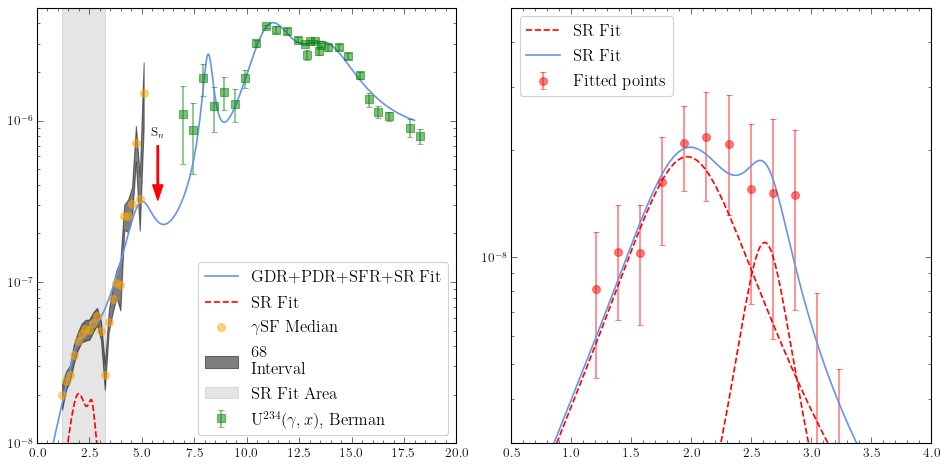

In [23]:
#Fit the pygmy resonances, in order to get the background for 
# the scissor resonance fit

params_SR = lmfit.Parameters()

if kevperbin120 == True:
    params_SR.add_many(('T_f',          p0[0],   False, p0[0]-1,      p0[0]+1),
                        ('E_SR1',       p0[13],  True,  minimum[13],  maximum[13]),
                        ('Gamma_SR1',   p0[14],  True,  minimum[14],  maximum[14]),
                        ('sigma_SR1',   p0[15],  True,  .1,  maximum[15]),
                        ('E_SR2',       p0[16],  True,  minimum[16],  maximum[16]),
                        ('Gamma_SR2',   p0[17],  True,  minimum[17],  maximum[17]),
                        ('sigma_SR2',   p0[18],  True,  minimum[18],  maximum[18]))


if kevperbin185 == True:
    params_SR.add_many(('T_f',          p0[0],   False, p0[0]-1,      p0[0]+1),
                        ('E_SR1',       p0[13],  True,  minimum[13],  maximum[13]),
                        ('Gamma_SR1',   p0[14],  True,  minimum[14],  maximum[14]),
                        ('sigma_SR1',   p0[15],  True,  minimum[15],  maximum[15]),
                        ('E_SR2',       p0[16],  True,  minimum[16],  maximum[16]),
                        ('Gamma_SR2',   p0[17],  True,  minimum[17],  maximum[17]),
                        ('sigma_SR2',   p0[18],  True,  minimum[18],  maximum[18]))

energy_SR = all_data_energy[SR_low_cut:SR_hi_cut]
data_SR = all_data[SR_low_cut:SR_hi_cut]
error_SR = all_data_error[SR_low_cut:SR_hi_cut]

for i in range(len(data_SR)):
    if data_SR[i]-f_fit_GLo(results_GLo.params, E=energy_SR[i])-f_fit_pygs(results_pygs.params, E=energy_SR[i])<0:
        data_SR[i] = 0
    else:
        data_SR[i] = data_SR[i]-f_fit_GLo(results_GLo.params, E=energy_SR[i])-f_fit_pygs(results_pygs.params, E=energy_SR[i])

        
def residuals_SR(parameters):
    return (f_fit_SR(parameters, energy_SR) - data_SR)**2/(error_SR**2)

results_SR = lmfit.minimize(fcn=residuals_SR, params=params_SR, method="leastsq")
print(results_SR.params.pretty_print())
p0[13:] = [results_SR.params['E_SR1'].value, results_SR.params['Gamma_SR1'].value,
           results_SR.params['sigma_SR1'].value, results_SR.params['E_SR2'].value, results_SR.params['Gamma_SR2'].value,
           results_SR.params['sigma_SR2'].value]
update_params(params, p0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

#plt.rcParams['text.usetex'] = False
# Initialize figure!


# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax1.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont)+f_fit_pygs(results_pygs.params, E=x_values_cont)+f_fit_SR(results_SR.params, E=x_values_cont), '-', color="cornflowerblue", label="GDR+PDR+SFR+SR Fit")
ax1.plot(x_values_cont, f_fit_SR(params, x_values_cont), '--', color="red", label="SR Fit")
ax1.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.5, label='68% Confidence\n Interval')
ax1.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange', alpha=0.5, label='$\gamma$SF Median')
ax1.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$, Berman ")
ax1.fill_between([energy_SR[0], energy_SR[-1]], [1,1], [0,0], color='black', alpha=0.1, label='SR Fit Area')
ax1.set_ylim(1e-8,5e-6)
ax1.set_xlim(0,20)
ax1.legend()
ax1.set_yscale('log')
ax1.legend(fontsize=15, frameon=True, facecolor='white', framealpha=.9, loc='lower right')
ax1.arrow(x=Sn, y=7e-7, dx=0, dy=-3e-7, width=0.08, head_width=.5, head_length=8e-8, color='r')
ax1.text(Sn-.3, 8e-7, "S$_n$")  

ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4), '--', color="red", label="SR Fit")
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=5), '--', color="red")
ax2.plot(x_values_cont, f_fit_SR(params, x_values_cont), '-', color="cornflowerblue", label="SR Fit")



ax2.errorbar(x=energy_SR, y=data_SR, yerr=error_SR, fmt='ro', alpha=.5, label='Fitted points')
ax2.set_ylim(3e-9,5e-8)
ax2.set_xlim(0.5,4)
ax2.set_yscale('log')
ax2.legend(fontsize=15, frameon=True, facecolor='white', framealpha=.9, loc='upper left')

In [24]:
#extract all parameters for plotting

#Define parameters & start values for the GLO
E_GLo1 = results_GLo.params['E_GLo1'].value
Gamma_GLo1 = results_GLo.params['Gamma_GLo1'].value
sigma_GLo1 = results_GLo.params['sigma_GLo1'].value
E_GLo2 = results_GLo.params['E_GLo2'].value
Gamma_GLo2 = results_GLo.params['Gamma_GLo2'].value
sigma_GLo2 = results_GLo.params['sigma_GLo2'].value
T_f    = results_GLo.params['T_f'].value

#pygmy resonance 1
E_pyg1 = results_pygs.params['E_pyg1'].value
Gamma_pyg1 = results_pygs.params['Gamma_pyg1'].value
sigma_pyg1 = results_pygs.params['sigma_pyg1'].value

#pygmy 2/spinflip resonance
E_pyg2 = results_pygs.params['E_pyg2'].value
Gamma_pyg2 = results_pygs.params['Gamma_pyg1'].value
sigma_pyg2 = results_pygs.params['sigma_pyg1'].value

#extract parameters from fit
E_SR1 = results_SR.params['E_SR1'].value
E_SR1_err = results_SR.params['E_SR1'].stderr
Gamma_SR1 = results_SR.params['Gamma_SR1'].value
Gamma_SR1_err = results_SR.params['Gamma_SR1'].stderr
sigma_SR1 = results_SR.params['sigma_SR1'].value
sigma_SR1_err = results_SR.params['sigma_SR1'].stderr

E_SR2 = results_SR.params['E_SR2'].value
E_SR2_err = results_SR.params['E_SR2'].stderr
Gamma_SR2 = results_SR.params['Gamma_SR2'].value
Gamma_SR2_err = results_SR.params['Gamma_SR2'].stderr
sigma_SR2 = results_SR.params['sigma_SR2'].value
sigma_SR2_err = results_SR.params['sigma_SR2'].stderr


In [25]:
#function for plotting total
def fit_plot_tot(par, E):
    """ make_fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR1'],     par['E_SR2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR1'], par['Gamma_SR2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR1'], par['sigma_SR2']])
    
    value = f_fit_GLo(results_GLo.params, E)+f_fit_pygs(results_pygs.params, E)+f_fit_SR(results_SR.params, E)
    return value

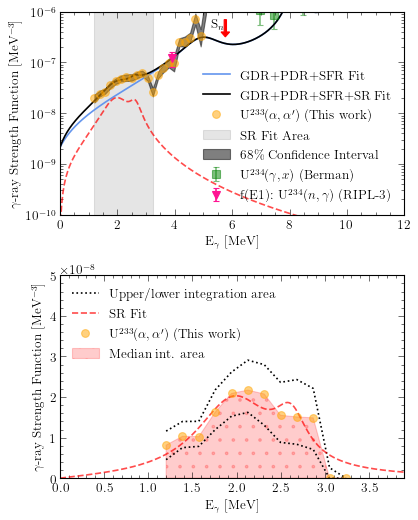

In [26]:
#Plotting total fit


x_values_cont = np.linspace(0, 18, 1000)

#(width, heigth) = set_size(subplots=(2,1))
#fig = plt.figure(figsize = (width,heigth+(heigth/4)))
fig = plt.figure(figsize = set_size(subplots=(2,1)))
gs = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])
#ax3 = plt.subplot(gs[0:1,0])


###
#Plot Integral area of SR and calculate the three different integral strengths
###

extraction_cont = f_fit_GLo(params, E=x_values_cont)+f_fit_pygs(params, E=x_values_cont)
extraction_int = f_fit_GLo(params, E=energy_gsf_ompy)+f_fit_pygs(params, E=energy_gsf_ompy)

ax1.fill_between([energy_SR[0], energy_SR[-1]], [1,1], [0,0], color='black', alpha=0.1, label='SR Fit Area')
ax1.plot(x_values_cont, f_fit_GLo(params, E=x_values_cont)+f_fit_pygs(results_pygs.params, E=x_values_cont), '-', color="cornflowerblue", label="GDR+PDR+SFR Fit")
ax1.plot(x_values_cont, fit_plot_tot(params, E=x_values_cont), '-', color="Black", label="GDR+PDR+SFR+SR Fit")
ax1.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4)+fit_plot_singular(params, E=x_values_cont, j=5),'--', color="red", alpha=0.7)
ax1.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$ (Berman) ")
ax1.fill_between(energy_gsf_ompy, gsf_error_lower, gsf_error_upper, color='black', alpha=0.5, label='68\% Confidence Interval')
ax1.plot(energy_gsf_ompy, gsf_ompy_median, marker='o', linestyle='',  color='orange', alpha=0.5, label='U$^{233}(\\alpha,\\alpha^\prime)$ (This work)')
ax1.errorbar(x=fEene, y=fEx, yerr=fEerr, xerr=None, fmt='v', color='deeppink', label="f(E1): U$^{234}(n,\gamma)$ (RIPL-3)")
    
ax1.arrow(x=Sn, y=7e-7, dx=0, dy=-3e-7, width=0.08, head_width=.3, head_length=8e-8, color='r')
ax1.text(Sn-.5, 5e-7, "S$_n$")    
    
#prepare data for integrating and plotting
energy = energy_gsf_ompy[SR_low_cut:SR_hi_cut]
data_upper = gsf_error_upper[SR_low_cut:SR_hi_cut]-extraction_int[SR_low_cut:SR_hi_cut]
data_lower = gsf_error_lower[SR_low_cut:SR_hi_cut]-extraction_int[SR_low_cut:SR_hi_cut]
data_median = gsf_ompy_median[SR_low_cut:SR_hi_cut]-extraction_int[SR_low_cut:SR_hi_cut]

#first, make sure negative points are set to zero in integral        
for i in range(len(energy)):
    if data_upper[i]<0:
        data_upper[i] = 0
    if data_lower[i]<0:
        data_lower[i] = 0
    if data_median[i]<0:
        data_median[i] = 0

#ax1.fill_between(energy, 0, color='red', alpha=0.2, label='Median Int. Area', hatch='.')
#ax1.plot(0, 0, ':', color='black', label='Up./Lo. Int. Area')
ax2.fill_between(energy, data_median, color='red', alpha=0.2, hatch='.', label='Median int. area')
ax2.plot(energy, data_lower, ':', color='black', label='Upper/lower integration area')
ax2.plot(energy, data_upper, ':', color='black')
ax2.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4)+fit_plot_singular(params, E=x_values_cont, j=5),'--', color="red", alpha=0.7, label='SR Fit')
ax2.plot(energy, data_median, marker='o', linestyle='',  color='orange', alpha=0.5, label='U$^{233}(\\alpha,\\alpha^\prime)$ (This work)')

ax1.legend(loc='lower right')
ax2.legend(loc='upper left')
#h, l = ax1.get_legend_handles_labels() 

ax2.set_xlabel('E$_\gamma$  [MeV]')
ax2.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax2.set_ylim(0, 5e-8)
ax2.set_xlim(0,3.9)
#ax2.set_yticks([1e-8,2e-8])
#ax2.set_yticklabels(['1e-8', '2e-8'])
ax1.set_ylim(1e-10, 1e-6)
ax1.set_xlim(0, 12)
ax1.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax1.set_xlabel('E$_\gamma$  [MeV]')
ax1.set_yscale('log')
if kevperbin120 == True:
    fig.savefig('SR_fit_120')
if kevperbin185 == True:
    fig.savefig('SR_fit_185')

In [32]:

#calculate trapezoidal integral of experimental points, with errors calculated from errorbars

integral_lower = np.trapz(data_lower, energy)
integral_upper = np.trapz(data_upper, energy)
integral_median = np.trapz(data_median, energy)

integral_centroid_median = np.trapz(data_median*energy, energy)
integral_centroid_upper = np.trapz(data_upper*energy, energy)
integral_centroid_lower = np.trapz(data_lower*energy, energy)

B_SR_hi = integral_upper * 2.598e8
B_SR_low = integral_lower * 2.598e8
B_SR_median = integral_median * 2.598e8
centroid_SR = integral_centroid_median/integral_median
centroid_SR_upper = integral_centroid_upper/integral_upper
centroid_SR_lower = integral_centroid_lower/integral_lower

print(centroid_SR_upper-centroid_SR)
print(centroid_SR-centroid_SR_lower)
print(energy)

print('B(SR) = %.3f in the range %.3f - %.3f with the centroid E_SR = %.3f in the range %.3f - %.3f'%(B_SR_median, B_SR_low, B_SR_hi, centroid_SR, centroid_SR_upper, centroid_SR_lower))


0.033006254065513385
0.05121277308191319
0     1.2025
1     1.3875
2     1.5725
3     1.7575
4     1.9425
5     2.1275
6     2.3125
7     2.4975
8     2.6825
9     2.8675
10    3.0525
11    3.2375
Name: 0, dtype: float64
B(SR) = 7.197 in the range 4.732 - 10.162 with the centroid E_SR = 2.141 in the range 2.174 - 2.090


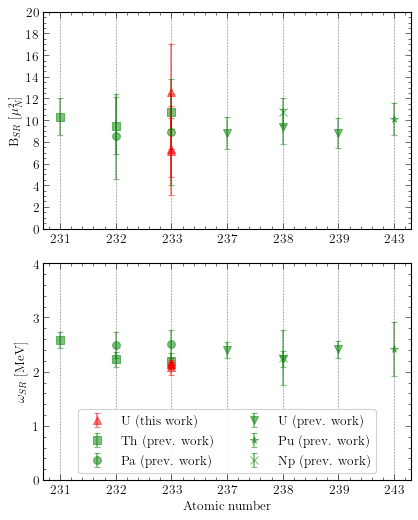

In [28]:
#plot the strength together with previous strengths

#A_ticks = ['231', '232', '233', '232', '233', '237', '238', '239', '243', '238']
Z_ticks = ['Thorium', 'Thorium', 'Thorium', 'Protactinium', 'Protactinium', 'Uranium', 'Uranium', 'Uranium', 'Plutonium', 'Neptunium']
marker = ['s', 's', 's', 'o', 'o', 'v', 'v', 'v', '*', 'x']
A_ticks = ['231', '232', '233', '237', '238', '239', '243']
A = [0,1,2,1,2,3,4,5,6,4]
B_SR = [10.3, 9.5, 10.8, 8.5, 8.9, 8.8, 9.4, 8.8, 10.1, 10.8]
B_SR_err = [1.7, 2.6, 1.6, 3.9, 4.9, 1.5, 1.6, 1.4, 1.5, 1.2]
omega_SR = [2.58, 2.23, 2.19, 2.49, 2.51, 2.40, 2.24, 2.41, 2.42, 2.26]
omega_SR_err = [.15, .14, .15, .24, .25, .14, .15, .15, .5, .5]

fig = plt.figure(figsize = set_size(subplots=(2,1)))
gs = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])

for i in range(len(A)):
    ax2.errorbar(x=A[i], y=omega_SR[i], yerr=omega_SR_err[i], fmt=marker[i], color='green', alpha=0.5)
    ax1.errorbar(x=A[i], y=B_SR[i], yerr=B_SR_err[i], fmt=marker[i], color='green', alpha=0.5)
    
for i in [0,1,2,3,4,5,6]:
    ax2.plot([i,i], [0, 5], ':', color='black', linewidth=.5);
    ax1.plot([i,i], [0, 23], ':', color='black', linewidth=.5);

ax2.errorbar(x=[2], y=[centroid_SR], yerr=[[centroid_SR-centroid_SR_lower], [centroid_SR_upper-centroid_SR]], fmt='^', color='red', alpha=0.5, label='U (this work)')
    
ax2.errorbar(x=0, y=-1, yerr=0, fmt='s', color='green', alpha=0.5, label='Th (prev. work)')
ax2.errorbar(x=0, y=-1, yerr=0, fmt='o', color='green', alpha=0.5, label='Pa (prev. work)')
ax2.errorbar(x=0, y=-1, yerr=0, fmt='v', color='green', alpha=0.5, label='U (prev. work)')
ax2.errorbar(x=0, y=-1, yerr=0, fmt='*', color='green', alpha=0.5, label='Pu (prev. work)')
ax2.errorbar(x=0, y=-1, yerr=0, fmt='x', color='green', alpha=0.5, label='Np (prev. work)')
ax2.legend(frameon=True, facecolor='white', framealpha=.9, ncol=2, loc='lower center')

ax1.errorbar(x=[2], y=7.197, yerr=[[7.197-4.732], [10.162-7.197]], fmt='^', color='red', alpha=0.5)
ax1.errorbar(x=[2], y=12.555, yerr=[[12.555-7.357], [16.982-12.555]], fmt='^', color='red', alpha=0.5)
ax1.errorbar(x=[2], y=7.345, yerr=[[7.345-3.051], [11.344-7.345]], fmt='^', color='red', alpha=0.5)


ax2.errorbar(x=[2], y=2.141, yerr=[[2.141-2.090], [2.174-2.141]], fmt='^', color='red', alpha=0.5)
ax2.errorbar(x=[2], y=2.181, yerr=[[2.181-2.080], [2.215-2.181]], fmt='^', color='red', alpha=0.5)
ax2.errorbar(x=[2], y=2.091, yerr=[[2.091-1.947], [2.138-2.091]], fmt='^', color='red', alpha=0.5)

ax1.set_ylim(0,20);
ax1.set_xticks([])
ax1.set_yticks(np.linspace(0,20,11))
ax1.set_xticks(np.linspace(0,6,7))
ax1.set_xticklabels(A_ticks)
ax1.set_ylabel('B$_{SR}$ [$\mu_N^2$]');

    
ax2.set_ylim(0,4);
ax2.set_xlabel('Atomic number');
ax2.set_xticks(np.linspace(0,6,7))
ax2.set_yticks(np.linspace(0,4,5))
ax2.set_xticklabels(A_ticks)
ax2.set_ylabel('$\omega_{SR}$ [MeV]');

if kevperbin120 == True:
    fig.savefig('SR_comparison')
if kevperbin185 == True:
    fig.savefig('SR_comparison')



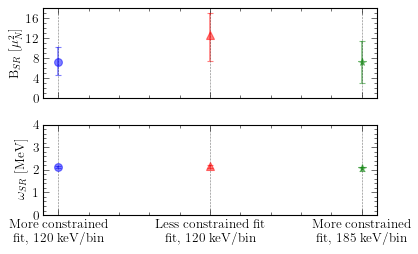

In [33]:
fig = plt.figure(figsize = set_size(subplots=(1,1)))
gs = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])
#B(SR) = 7.197 in the range 4.732 - 10.162 with the centroid E_SR = 2.141 in the range 2.174 - 2.090
#B(SR) = 12.878 in the range 7.679 - 17.305 with the centroid E_SR = 2.181 in the range 2.213 - 2.082
#B(SR) = 7.345 in the range 3.051 - 11.344 with the centroid E_SR = 2.091 in the range 2.138 - 1.947
ax1.errorbar(x=[1], y=7.197, yerr=[[7.197-4.732], [10.162-7.197]], fmt='o', color='blue', alpha=0.5)
ax1.errorbar(x=[2], y=12.555, yerr=[[12.555-7.357], [16.982-12.555]], fmt='^', color='red', alpha=0.5)
ax1.errorbar(x=[3], y=7.345, yerr=[[7.345-3.051], [11.344-7.345]], fmt='*', color='green', alpha=0.5, label='More\n constrained \n fit\n 185 keV/bin')
ax1.set_ylim(0,18)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels([])
ax1.set_yticks(np.linspace(0,16,5))
ax1.plot([1,1], [0,20], ':', color='black', linewidth=.5)
ax1.plot([2,2], [0,20], ':', color='black', linewidth=.5)
ax1.plot([3,3], [0,20], ':', color='black', linewidth=.5)
ax1.set_ylabel('B$_{SR}$ [$\mu_N^2$]');
#ax1.legend(loc='upper left')

ax2.errorbar(x=[1], y=2.141, yerr=[[2.141-2.090], [2.174-2.141]], fmt='o', color='blue', alpha=0.5, label='More\n constrained \n fit\n 120 keV/bin')
ax2.errorbar(x=[2], y=2.181, yerr=[[2.181-2.080], [2.215-2.181]], fmt='^', color='red', alpha=0.5, label='Less\n constrained\n fit')
ax2.errorbar(x=[3], y=2.091, yerr=[[2.091-1.947], [2.138-2.091]], fmt='*', color='green', alpha=0.5)
ax2.set_xticks([1,2,3])
ax2.set_yticks([0,1,2,3,4])
ax2.set_xticklabels(['More constrained \n fit, 120 keV/bin', 'Less constrained fit \n fit, 120 keV/bin', 'More constrained \n fit, 185 keV/bin'])
ax2.plot([1,1], [-20,20], ':', color='black', linewidth=.5)
ax2.plot([2,2], [-20,20], ':', color='black', linewidth=.5)
ax2.plot([3,3], [-20,20], ':', color='black', linewidth=.5)
ax2.set_ylim(0,4)
ax2.set_ylabel('$\omega_{SR}$ [MeV]');
#ax2.legend(ncol=2)

fig.savefig('SR_method_comparison')

In [30]:
debug_mode=1
if debug_mode:
    """ This plots out the initial guess and optimised parameters and their min/max limits for the fit.
    This is meant to """
    fig, ax = plt.subplots(figsize=(20,10))
    
    D = input_params.valuesdict()
    X = range(len(D))
    R = params.valuesdict()
    ax.plot(X, list(R.values()), 'ro', label='Result value')
    ax.plot(X, list(D.values()), 'bo', label='Input value')
    
    ax.plot(X, minimum, color="grey", label="min")
    ax.plot(X, maximum, color="grey", label="max")

    
    ax.set_xticks(X)
    ax.tick_params(axis='x', which='major', labelsize=10, direction='out')
    ax.set_xticklabels(list(R.keys()))
    
    ax.set_yscale("log")
    ax.legend()
    fig.show()

RuntimeError: latex was not able to process the following string:
b'T_f'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/tellefs/.matplotlib/tex.cache/7daec1bb6944c6c2ab26e9e1ceacadae.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./7daec1bb6944c6c2ab26e9e1ceacadae.aux)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily T_
                  f}
No pages of output.
Transcript written on 7daec1bb6944c6c2ab26e9e1ceacadae.log.




<Figure size 1600x800 with 1 Axes>

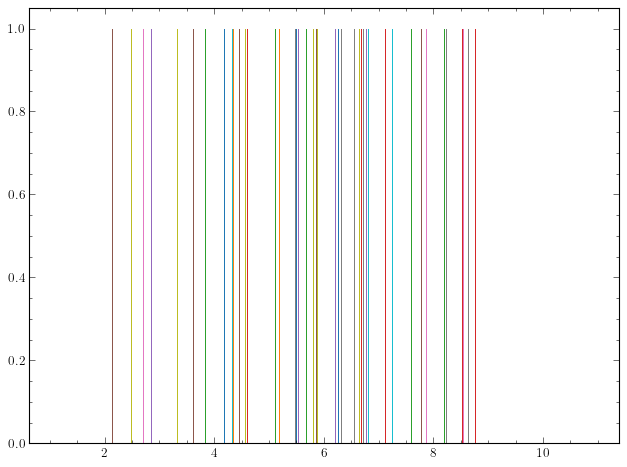

In [31]:
array = []
for i in range(100):
    array.append(np.random.default_rng().poisson([5]))

    
plt.hist(array)
plt.show()